In [1]:
## Standard libraries
from PIL import Image
import numpy as np
import cv2

## Imports for plotting
import matplotlib.pyplot as plt

## PyTorch
import torch

## Torchvision
from torchvision import transforms

## EuroSAT and ViT
import sys
sys.path.append('../architectures/ViT')
from architectures.ViT.predict import get_pretrained_model_EuroSAT, get_transform_EuroSAT, get_vit_EuroSAT

/Users/m.hidalgo/.local/share/virtualenvs/vit-hij5KBdv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
# List of image to be predicted
list_images = [
    "../data/2750/Highway/Highway_1.jpg",
    "../data/2750/Industrial/Industrial_1.jpg",
    "../data/2750/River/River_1.jpg",
    "../data/2750/River/River_5.jpg",
    "../data/2750/River/River_7.jpg",
    "../data/2750/River/River_8.jpg",
    "../data/google.jpg"
]

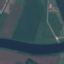

In [50]:
image_to_be_predicted = Image.open(list_images[3])
image_to_be_predicted

In [44]:
IMAGE_SIZE=64
PATCH_SIZE=16
MODEL_DIR=f"../weights/ViT/image_{IMAGE_SIZE}/patch_{PATCH_SIZE}/best.pt"

In [45]:
# Get the model trained
model_saved = get_pretrained_model_EuroSAT(best_weights_file=MODEL_DIR)
model = get_vit_EuroSAT(image_size=IMAGE_SIZE, patch_size=PATCH_SIZE)
model.load_state_dict(model_saved['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

ViT bias numel 10


VisionTransformer(
  (input_layer): Linear(in_features=768, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Laye

In [52]:
# Normalize the image to be predicted
tr = get_transform_EuroSAT(image_size=IMAGE_SIZE)
normalization = model_saved['normalization']
tr.transforms.append(transforms.Normalize(**normalization))
x = tr(image_to_be_predicted)

In [53]:
# Calculate the attention matrix
logits, att_mat = model(x.unsqueeze(0))
attention_weights = torch.stack(att_mat).squeeze(1)

In [54]:
# Average the attention weights across all heads
attention_weights_head_mean = torch.mean(attention_weights, dim=1)

In [55]:
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(attention_weights_head_mean.size(1))

In [56]:
aug_att_mat = attention_weights_head_mean + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

In [59]:
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), image_to_be_predicted.size)[..., np.newaxis]
result = (mask * image_to_be_predicted).astype("uint8")

Prediction Label and Attention Map!

0.99171 : River
0.00359 : Highway
0.00345 : Pasture
0.00074 : Annual Crop
0.00043 : Permanent Crop


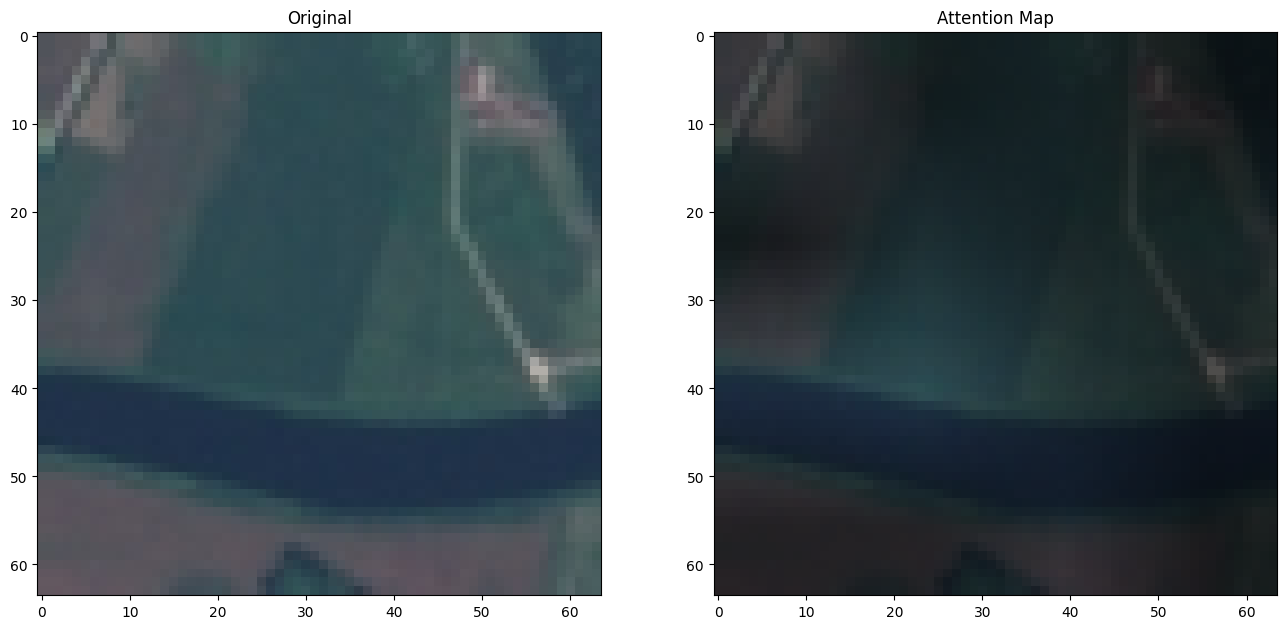

In [21]:
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
EuroSAT_labels = dict(enumerate(open('../data/EuroSATLabels.txt')))
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {EuroSAT_labels[idx.item()]}', end='')

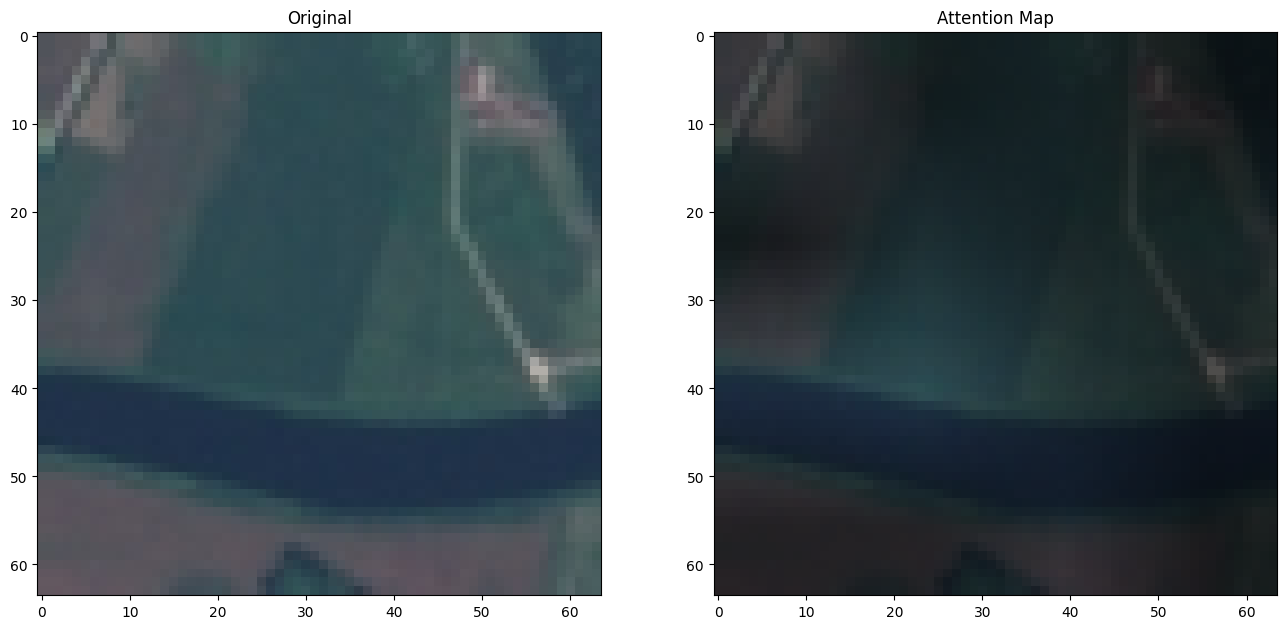

In [60]:
# Plot Result Attention Map
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image_to_be_predicted)
_ = ax2.imshow(result)

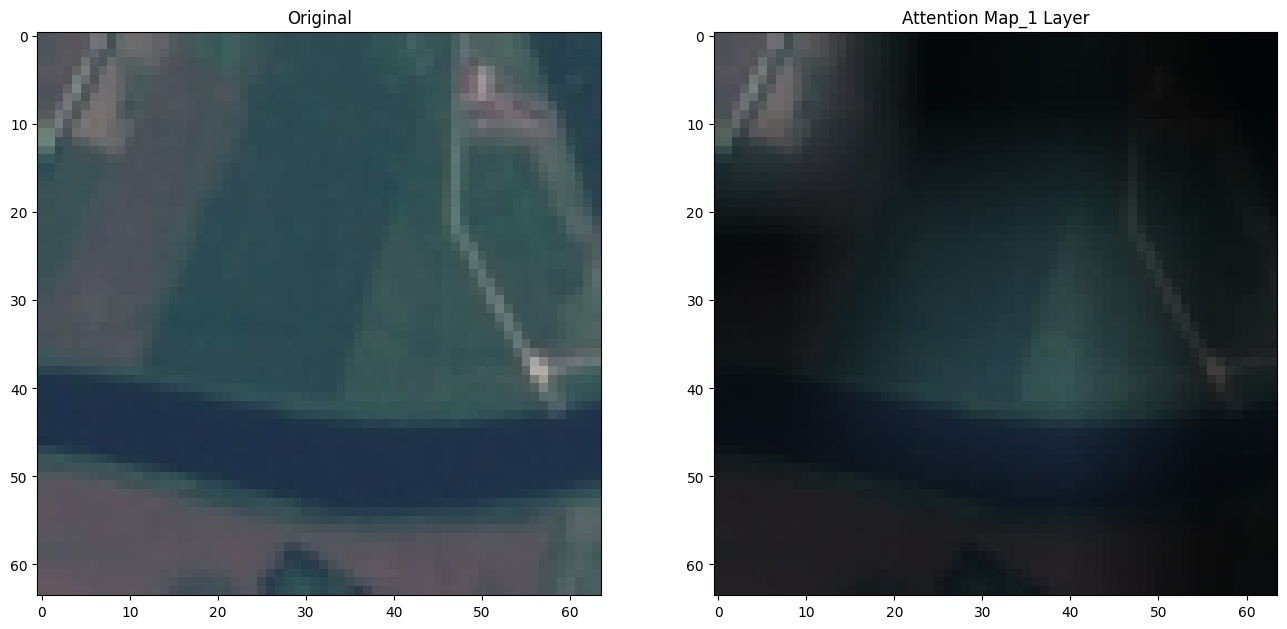

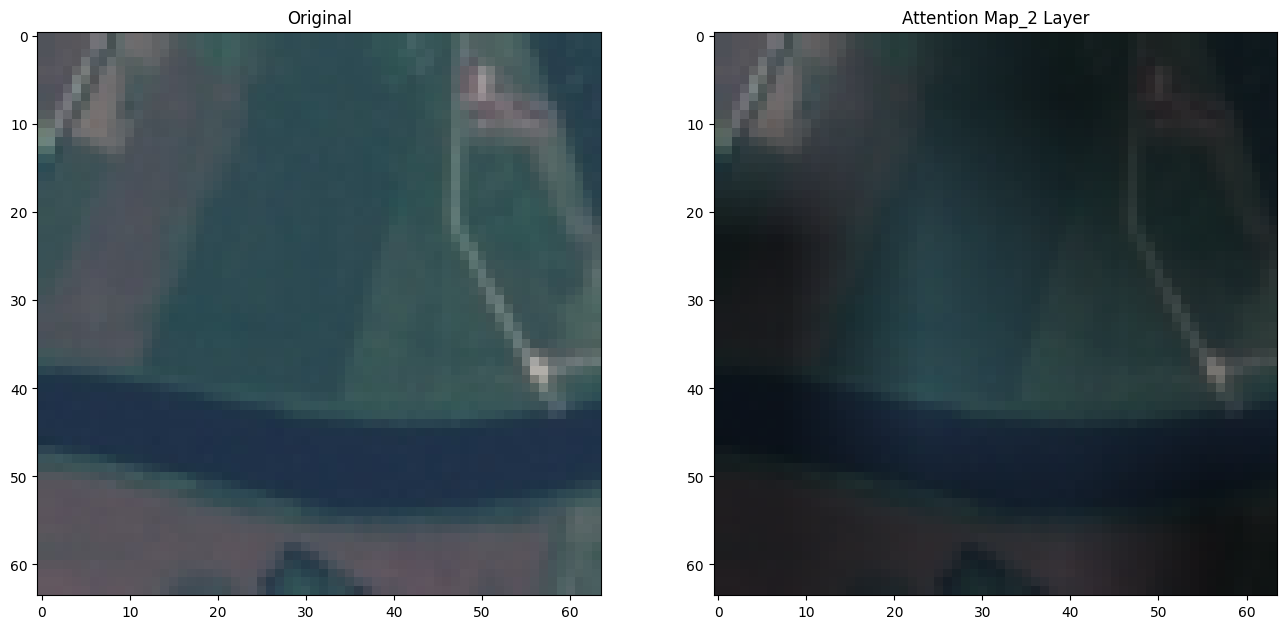

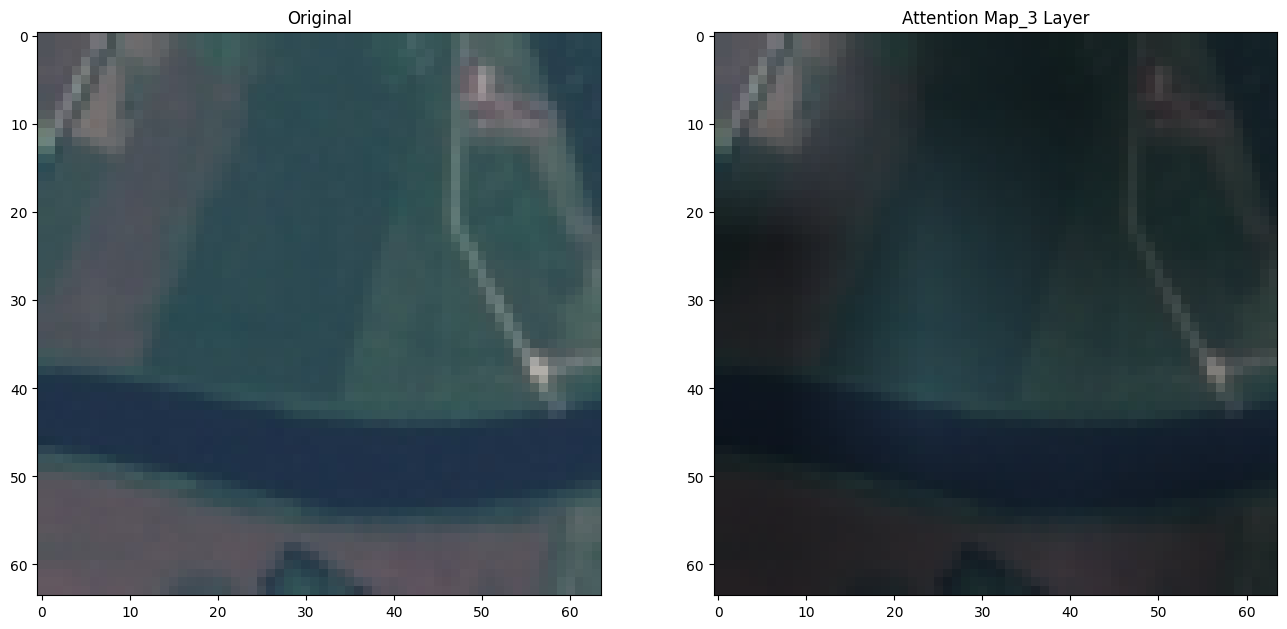

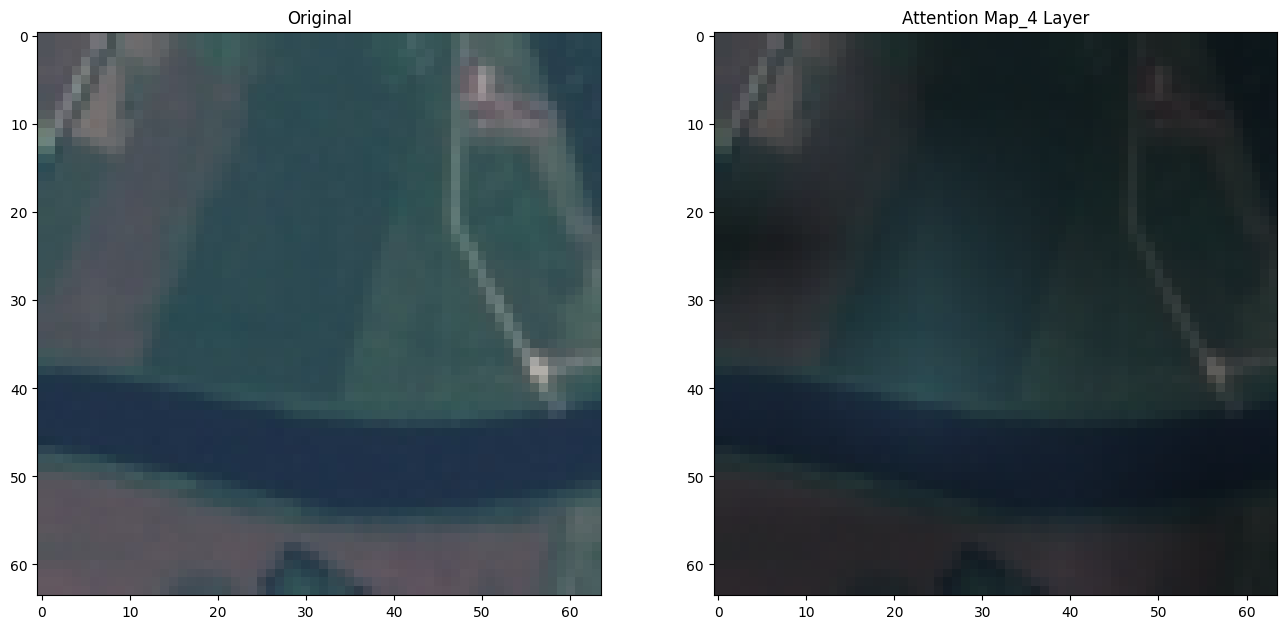

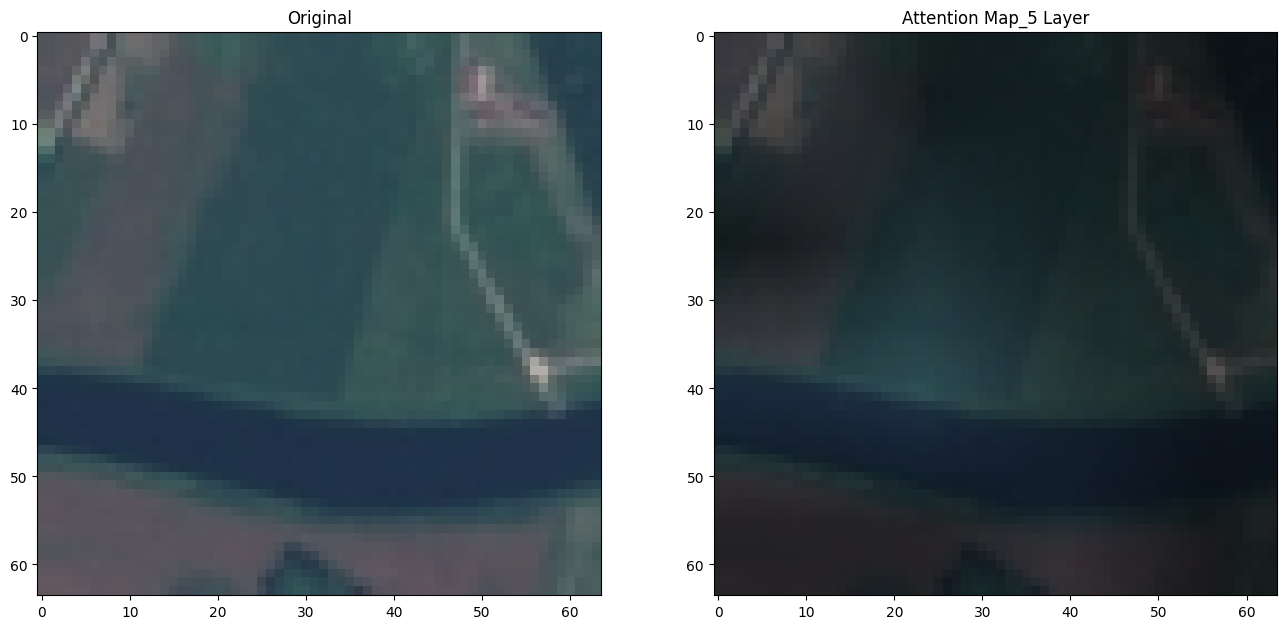

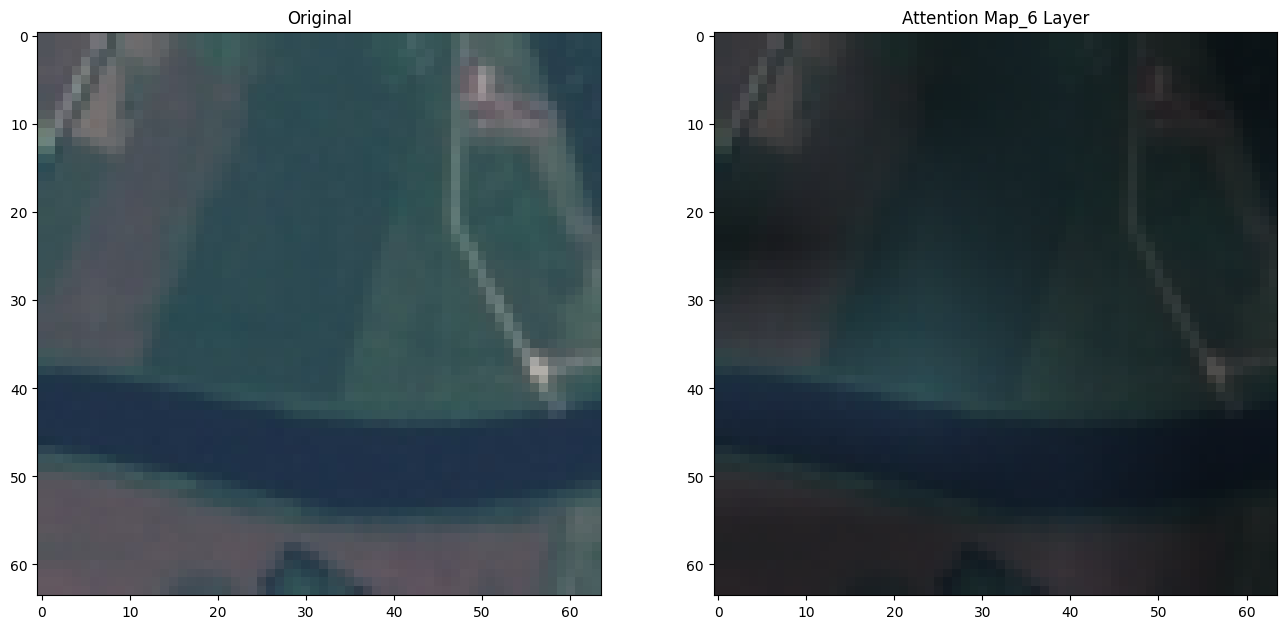

In [23]:
# Plot Attention Map for each layer
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), image_to_be_predicted.size)[..., np.newaxis]
    result = (mask * image_to_be_predicted).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(image_to_be_predicted)
    _ = ax2.imshow(result)
